In [1]:
# !pip install emcee corner

import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import astropy.time
import astropy.units as u
import astropy.constants as c
import corner
import emcee

custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
                   "/DSPS_WFortino/main/custom.mplstyle")
plt.style.use(custom_mplstyle)

# Read in the input dataset (1 point)

In [2]:
csv_file = ("https://raw.githubusercontent.com/fedhere/DSPS_FBianco"
            "/master/midterm/grb050525A.csv")
grbAG = pd.read_csv(csv_file)
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit
114,W1,63738,21.20,NaN,1
115,M2,74798,21.59,NaN,1
116,U,128928,20.05,NaN,1
117,V,971360,22.09,NaN,1
118,V,1171176,21.16,NaN,1


# 2 Visualize the data (2 points)

In [4]:
# Set the NaN magerr values to the median of the other values.
nan_ind = np.isnan(grbAG["magerr"].values)
med_magerr = np.median(grbAG["magerr"].values[~nan_ind])
grbAG["magerr"][nan_ind] = med_magerr

<ipython-input-4-bc0287973004>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grbAG["magerr"][nan_ind] = med_magerr


In [5]:
def visualize(grbAG, col="time", upperlimits=True):    
    fig, ax = plt.subplots()
    
    colors = np.unique(grbAG["filter"].values)
    nColors = len(colors)
    cmap = plt.cm.get_cmap("hsv", nColors)

    for i, c in enumerate(colors):
        c_mask = grbAG["filter"] == c
        c_data = grbAG[c_mask]
        color = cmap(i)
        ax.errorbar(c_data[col], c_data.mag,
                    yerr=c_data.magerr, c=color,
                    label=c, elinewidth=1, capsize=4)
        
        if not upperlimits:
            continue

        for row in c_data.itertuples():
            if row.upperlimit:
                m = "x"
            else:
                m = "."
                
            if col == "time":
                x = row.time
                xlabel = "Time [s]"
            elif col == "log10time":
                x = row.log10time
                xlabel = "Log10 Time"
                
            ax.scatter(x, row.mag, marker=m, color=color)
            
    if col == "time":
        xlabel = "Time [s]"
    elif col == "log10time":
        xlabel = "Log10 Time"

    plt.xlabel(xlabel)
    plt.ylabel("Flux [mag]")

    plt.gca().invert_yaxis()
    plt.legend()
    return ax
    plt.show()

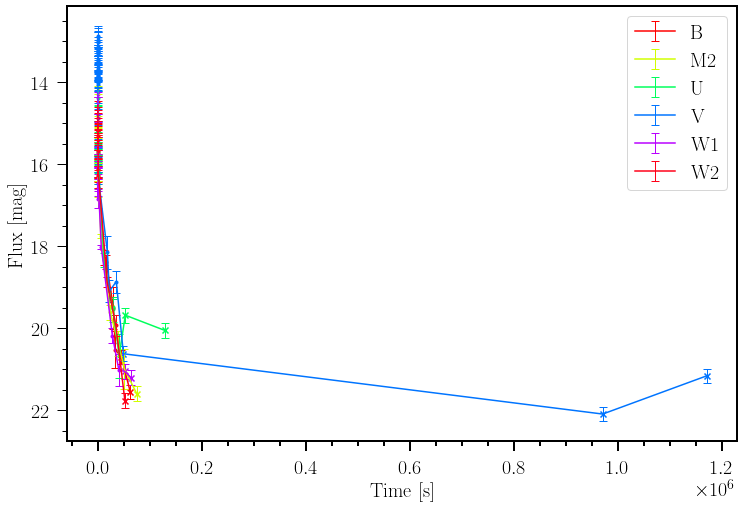

In [6]:
ax = visualize(grbAG)

### Figure 1: Photometric GRB data plotted. Each color represents a different optical filter as shown by the legend. Data points marked with an x denote an upper limit. Uncertainties for measurements with no uncertainty are set to the mean of the rest of the dataset.

# 3 Create the log-time variable (1 point)

In [7]:
# Make log10time column
grbAG["log10time"] = np.log10(grbAG["time"])

# 4 Plot the data in log space (1 point)

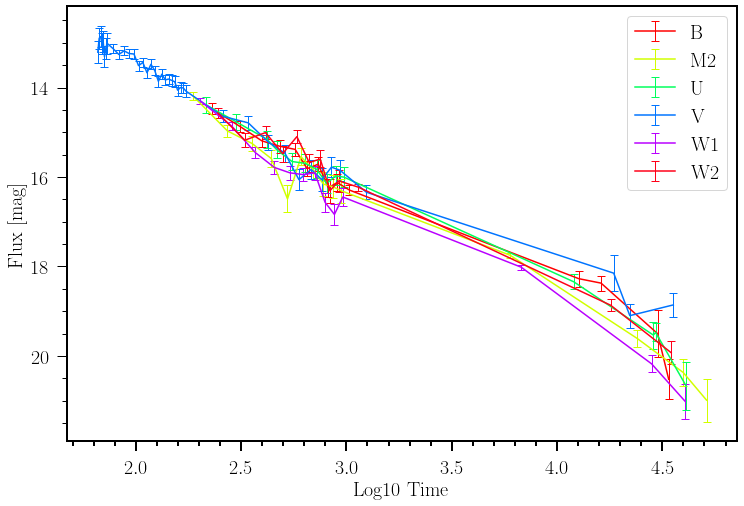

In [8]:
upperlimits_ind = grbAG["upperlimit"].astype(bool).values
grbAG_nul = grbAG[~upperlimits_ind]

ax = visualize(grbAG_nul, col="log10time", upperlimits=False)

### Figure 2: GRB Photometric data plotted against log10 time. Each color represents a different photometric filter as shown by the legend. Upper limits not plotted. Note how the dataset appears to be log-linear.

# 5 (661) Solve using the Normal Equation (2 points)

In [9]:
def linear_fit(X, Y, sigma_y):
    A = np.vstack((np.ones_like(X), X)).T
    C = np.diag(sigma_y**2)

    C_inv = np.linalg.inv(C)
    A_T = A.T
    
    cov = np.linalg.inv(A_T @ C_inv @ A)
    b, m = cov @ (A_T @ C_inv @ Y)
    
    return b, m, cov


def linear_model(x, b, m):
    return b + m * x

In [10]:
X = grbAG_nul["log10time"].values
Y = grbAG_nul["mag"].values
Yerr = grbAG_nul["magerr"].values

norm_b, norm_m, norm_cov = linear_fit(X, Y, Yerr)
print("Best fit parameters from the Normal Equation:\n"
      f"    Slope: {norm_m:.4f} ± {np.sqrt(norm_cov[1, 1]):.4f}\n"
      f"    Intercept: {norm_b:.4f} ± {np.sqrt(norm_cov[0, 0]):.4f}")

Best fit parameters from the Normal Equation:
    Slope: 2.4802 ± 0.0201
    Intercept: 8.5995 ± 0.0558


# 6 (661) Fit a line with a prepackaged function (2 points)

In [11]:
popt, pcov = sp.optimize.curve_fit(linear_model, X, Y,
                                   sigma=Yerr, absolute_sigma=True)
print("Best fit parameters from the scipy.optimize.curve_fit:\n"
      f"    Slope: {popt[1]:.4f} ± {np.sqrt(pcov[1, 1]):.4f}\n"
      f"    Intercept: {popt[0]:.4f} ± {np.sqrt(pcov[0, 0]):.4f}")

Best fit parameters from the scipy.optimize.curve_fit:
    Slope: 2.4802 ± 0.0201
    Intercept: 8.5995 ± 0.0558


# 7 Fit a line to the data by minimizing an objective function (3 points)

In [12]:
def chisq(theta, x, y, yerr, func):
    chisq = np.sum((y - func(x, *theta))**2 / yerr**2)
    return chisq


def linear_model_prime(x, b, m):
    return m

In [13]:
p0 = (1, 1)
args = (X, Y, Yerr, linear_model)
opt = sp.optimize.fmin_slsqp(chisq, p0, args=args)

print("Best fit parameters from minimizing chi-squared:\n"
      f"    Slope: {opt[1]:.4f}\n"
      f"    Intercept: {opt[0]:.4f}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 317.420669801409
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Best fit parameters from minimizing chi-squared:
    Slope: 2.4802
    Intercept: 8.5995


### We choose the chi-squared loss function because we know that the optimal solution for linear regression is equivalent to minimizing the chi-squared.

# 8 Plot all the solutions (2 points)

In [14]:
def addline(ax, x, line, m, b, name, ls):
    ax.plot(x, line(x, b, m),
            c="k", ls=ls, label=name)

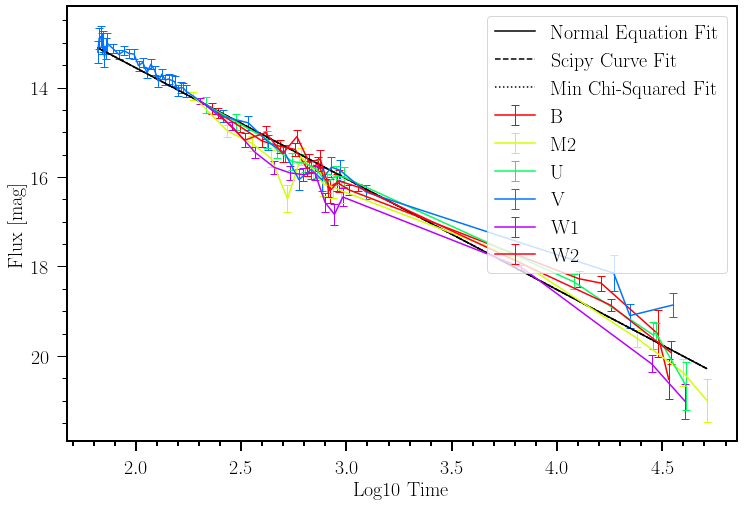

In [15]:
ax = visualize(grbAG_nul, col="log10time", upperlimits=False)

addline(ax, X, linear_model, norm_m, norm_b, "Normal Equation Fit", ls="-")
addline(ax, X, linear_model, popt[1], popt[0], "Scipy Curve Fit", ls="--")
addline(ax, X, linear_model, opt[1], opt[0], "Min Chi-Squared Fit", ls=":")

plt.legend(loc="upper right")
plt.show()

### Figure 3: GRB Photometric data plotted against log10 time. Each color represents a different photometric filter as shown by the legend. Upper limits not plotted. Three different linear fits are plotted in black. Each of the fits agree to within at least four decimal places in slope and intercept.

# 9 Create a table with the results of each method (1 point)

| Parameter | Normal Equation | Scipy Optimize Curve Fit | Scipy Minimize Chisq |
| --- | --- | --- | --- |
| b | 8.5995 | 8.5995 | 8.5995 |
| m | 2.4802 | 2.4802 | 2.4802 |

# 10 Now try MCMC: fit a line with MCMC using emcee (3 points)

In [16]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    yhat = m * x + b
    chisq = -0.5 * np.sum((y - yhat)**2 / (yerr**2))
    return chisq


def log_prior(theta):
    m, b = theta
    if (0 < b < 30) and (0 < m < 25):
        return 0.0
    return -np.inf


def log_prob(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

### Priors -25 < b < 30 and 0 < m < 25 were chosen as very generous bounds. We know that slope must be positive because of the nature of the data, and will likely be less than 25. We choose -25, the approximate magnitude of the sun, as the lower bound for b. We choose 25, a few magnitudes beyond the faintest limit for state of the art observatories, as the upper bound for b.

In [17]:
p0 = np.array([norm_m, norm_b], dtype=float)
nWalkers = 32
nDim = p0.size

rng = np.random.RandomState(193)
pos = p0 + 1e-4 * sp.stats.norm.rvs(loc=0, scale=1,
                                    size=(nWalkers, nDim), random_state=rng)
pos.shape

(32, 2)

In [18]:
sampler = emcee.EnsembleSampler(nWalkers, nDim, log_prob,
                                args=(X, Y, Yerr))

In [19]:
final_state = sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:08<00:00, 566.27it/s]


In [20]:
tau = sampler.get_autocorr_time()
tau

array([28.79974687, 28.64883934])

<Figure size 720x720 with 0 Axes>

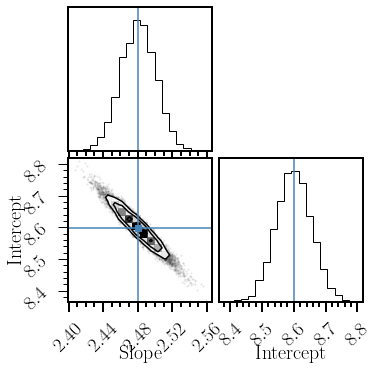

In [21]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)

plt.figure(figsize=(10, 10))
labels = ["Slope", "Intercept"]
truths = [norm_m, norm_b]
fig = corner.corner(flat_samples, labels=labels, truths=truths)
plt.show()

### Figure 4: Marginalized distributions for the log-linear model of the GRB afterglow events. "Truth" parameters are calculated from the Normal Equation linear fit.

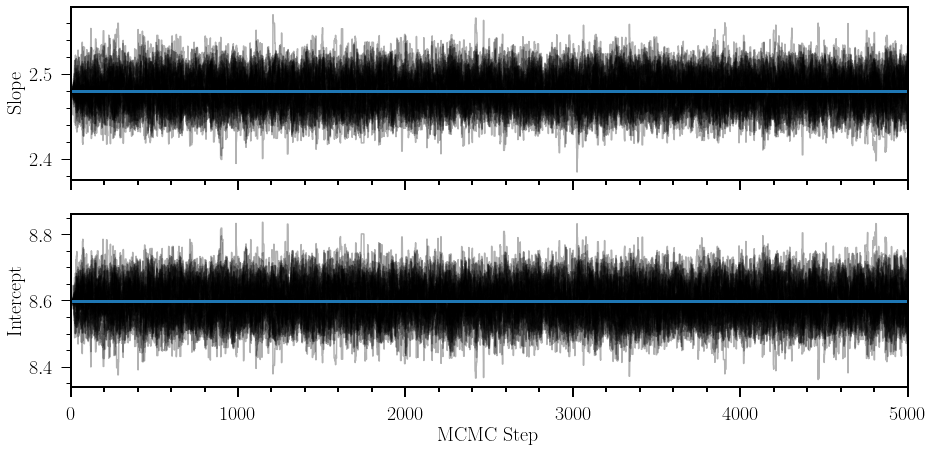

In [22]:
fig, axes = plt.subplots(nrows=nDim, ncols=1,
                         sharex=True, figsize=(15, 7))
samples = sampler.get_chain(discard=0)

for i in range(nDim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[0].axhline(y=norm_m, c="tab:blue", lw=3)
axes[1].axhline(y=norm_b, c="tab:blue", lw=3)
    
axes[-1].set_xlabel("MCMC Step")
plt.show()

### Figure 5: MCMC Chains for the slope and the intercept paramter. Truth value plotted in blue obtained from the Normal Equation linear fit. This MCMC model performs well given the fact that the burn-in period appears to be small, and the walkers find the peak of the posterior quite quickly.

In [23]:
theta0 = []
for i in range(nDim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    std = np.std(flat_samples[:, i])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.2f} ± {q[1]:.2f}")
    theta0.append(mcmc[1])
theta0

Slope: 2.48 ± 0.02
Intercept: 8.60 ± 0.06


[2.480509831388197, 8.598344187527523]

# 11 (661) Fit a more correct model: a "broken power law" (3 points)

In [24]:
def logF(t, b, a1, a2, Tb):
    mag = b - np.log10((t/Tb)**(-a1) + (t/Tb)**(-a2))
    return mag
    

def log_likelihood(theta, t, y, yerr):
    b, a1, a2, Tb = theta
    yhat = logF(t, b, a1, a2, Tb)
    chisq = -0.5 * np.sum((y - yhat)**2 / (yerr**2))
    return chisq


def log_prior(theta):
    b, a1, a2, Tb = theta
    if (0 < b < 30) and (0 < a1 < 25) and (0 < a2 < 25) and (0 < Tb < 1e7):
        return 0.0
    return -np.inf


def log_prob(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

### Prior was again chosen based on the physics of the problem. Slopes a1 and a2 were chosen knowing that the slope should be positive and likely less than 25. b was chosen the same as above, and Tb was chosen based on what we know about the time series of the data.

In [26]:
t = grbAG_nul["time"].values

p0 = np.array([norm_b, norm_m, norm_m, 0.1*10**6], dtype=float)
nWalkers = 50
nDim = p0.size

pos = p0 + 1e-4 * sp.stats.norm.rvs(loc=0, scale=1,
                                    size=(nWalkers, nDim), random_state=rng)
sampler = emcee.EnsembleSampler(nWalkers, nDim, log_prob,
                                args=(t, Y, Yerr))
final_state = sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 35000/35000 [01:42<00:00, 340.89it/s]


<Figure size 720x720 with 0 Axes>

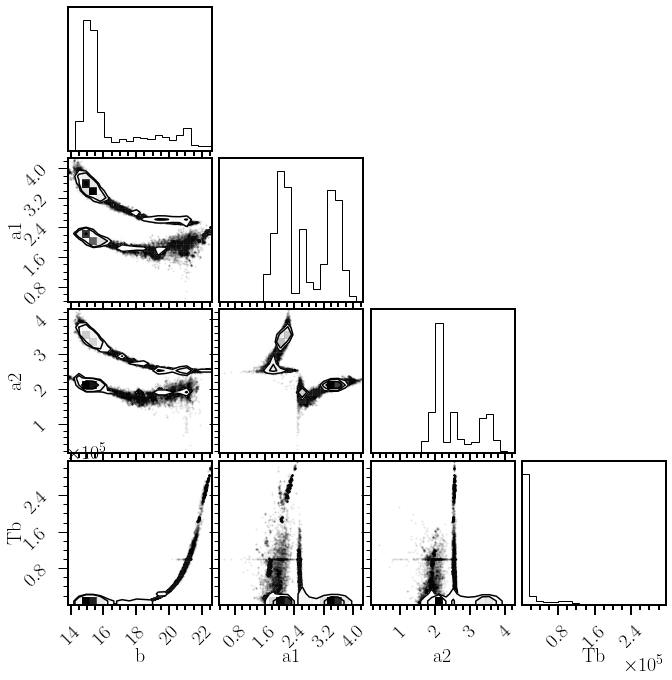

In [27]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)

plt.figure(figsize=(10, 10))
labels = ["b", "a1", "a2", "Tb"]
fig = corner.corner(flat_samples, labels=labels)
plt.show()

### Figure 6: Marginalized distributions for the broken power law model of the GRB afterglow events. In this case, the MCMC algorithm did not uncover a smooth or simple posterior distribution.

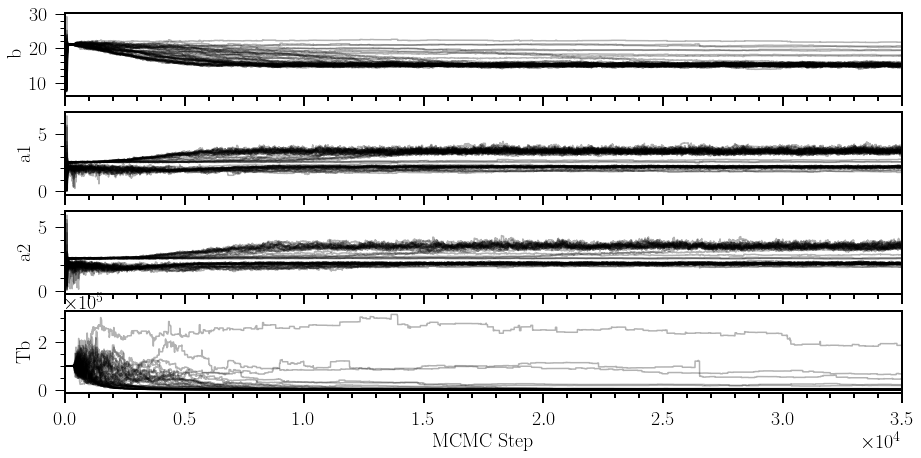

In [28]:
fig, axes = plt.subplots(nrows=nDim, ncols=1,
                         sharex=True, figsize=(15, 7))
samples = sampler.get_chain(discard=0)

for i in range(nDim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("MCMC Step")
plt.show()

### Figure 7: MCMC Chains for the broken power law model parameters. Generally these walkers agree though perhaps longer chain length or moore walkers is required for better agreement between the walkers.

In [29]:
theta1 = []
for i in range(nDim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    std = np.std(flat_samples[:, i])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.2f} ± {q[1]:.2f}")
    theta1.append(mcmc[1])
theta1

b: 15.45 ± 4.10
a1: 2.55 ± 0.97
a2: 2.20 ± 1.24
Tb: 382.39 ± 21094.46


[15.446812143521402, 2.551895547445806, 2.2018706516140796, 382.3853220874708]

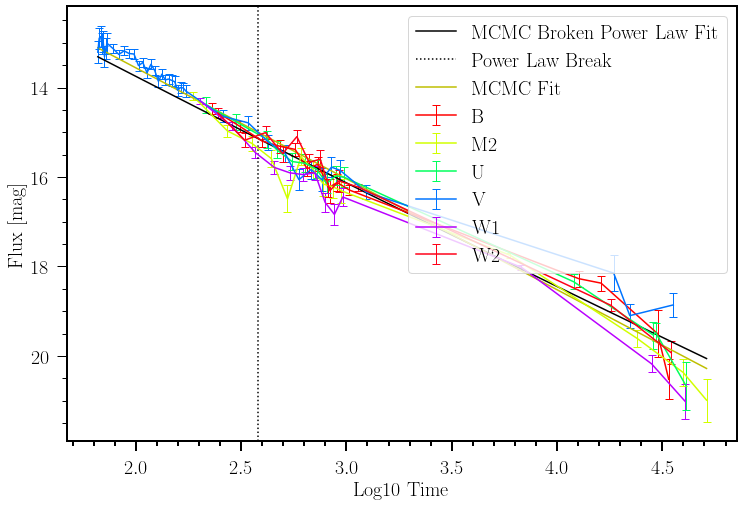

In [38]:
ax = visualize(grbAG_nul, col="log10time", upperlimits=False)
ax.plot(np.log10(t), logF(t, *theta1), c="k", label="MCMC Broken Power Law Fit")
ax.axvline(x=np.log10(theta1[3]), c="k", ls=":", label="Power Law Break")

ax.plot(X, linear_model(X, theta0[1], theta0[0]), c="y", label="MCMC Fit")

plt.legend(loc="upper right")

### Figure 8: MCMC is used to fit a log-linear model as well as a broken power law model. In the broken power law model, the break happens at t = 382.